In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns

from utils.utils import *
from utils.model_cv import *
from utils.model_vis import *

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier, XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
path="./Models/start_196601_end_202005_test_200610/"
predicted_feature = 'Fed_rate_month_avg_diff'
SEED = 100
with_pca = True

In [3]:
file_names = get_file_names(path=path, extension=".csv")
X_test, X_train, Y_test, Y_train = open_files(path=path,
                                              file_names=file_names
                                             ).values()
Y_train['Date'] = pd.to_datetime(Y_train['Date'])
Y_test['Date'] = pd.to_datetime(Y_test['Date'])
X_train.drop(columns=["Date"], inplace=True)
X_test.drop(columns=["Date"], inplace=True)
excl_cols = ["Fed_rate_spot_EOM",
         "Fed_rate_month_avg_diff_3_class", "Fed_rate_month_avg_diff_5_class",
         "Fed_rate_month_avg_diff_9_class", "Fed_rate_month_avg_trend"]
excl_cols = [x for x in X_train.columns if x.split("_t-")[0] in excl_cols]
X_train.drop(columns=excl_cols, inplace=True)
X_test.drop(columns=excl_cols, inplace=True)

In [4]:
features_info = open_file("./config/features_info.yaml")
num_cols = [x for x in X_train.columns if x.split("_t-")[0] in features_info["numeric features"]]
vif, excl_cols_vif = vif_analysis(X_train, columns=num_cols, excl_cols=[], threshold=10)

------------------------------------------ VIF analysis starting: 85 features ------------------------------------------
------------------------------------------ VIF analysis succesfully completed ------------------------------------------
remaining features: 70
excluded features: 15


In [5]:
X_train.drop(columns=excl_cols_vif, inplace=True)
X_test.drop(columns=excl_cols_vif, inplace=True)

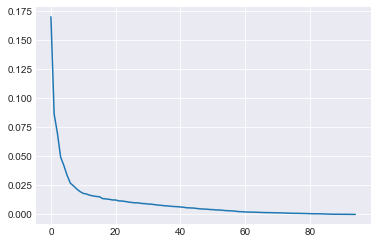

In [6]:
pca_ = pca(data=X_train, n_components=len(X_train.columns), plot_explained_var=False)
plt.style.use("seaborn-darkgrid")
plt.plot(pca_.explained_variance_ratio_)
plt.show()

In [7]:
# # XGB finetuning
estimator = XGBRegressor()
cv_params = {
#     'n_estimators': [200],
#     'learning_rate': [0.05, 0.1, 0.3],
#     'learning_rate': [0.05],
    'learning_rate': [float(x) for x in np.logspace(-3, -1, 15)],
    'n_estimators': list(range(50, 500, 50)),
#     'max_depth': np.arange(3, 50, 2),
#     'min_child_weight': np.arange(2, 15, 1),
#     'max_depth': [15],
#     'min_child_weight': [3],
#     'gamma': [i/50.0 for i in range(50)],
#     'gamma': [0],
#     'subsample': np.linspace(0.5, 1, 21),
#     'colsample_bytree': np.linspace(0.6, 1, 17),
#     'subsample': [1],
#     'reg_alpha': np.logspace(-5, 0, 21),
#     'reg_alpha': [5e-4]
}

# Linear Regression
# estimator = LinearRegression()
# cv_params = {}

# RF finetuning
# cv_params={
# #     'max_features': np.arange(2, 50, 2),
#     'max_features': [16],
# #     'n_estimators': list(np.arange(100, 5100, 100)),
# #     'n_estimators': list(np.arange(10, 101, 10)) + [900, 1300, 1700, 2100],
#     'n_estimators': [2100],
# #     'max_depth': list(np.arange(1, 25, 2)) + [25, 50, 100, 200],
#     'max_depth': [7],
#     'min_samples_split': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
#     'min_samples_leaf': np.arange(1, 15, 1)
# }


print(cv_params)
if with_pca:
    cv_params = {
        estimator.__class__.__name__ + "__" + k: v for k, v in cv_params.items()
    }

{'learning_rate': [0.05], 'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450]}


In [8]:
if with_pca:
    n_components=[10, 15, 20]
    cv_params["pca__n_components"] = list(n_components)

    pipe = Pipeline([
        ("pca", PCA(random_state = SEED)),
        (estimator.__class__.__name__, estimator.set_params(random_state=SEED))
    ])

else:
    pipe = Pipeline([
        (estimator.__class__.__name__, estimator.set_params(random_state=SEED))
    ])

In [9]:
g = cross_validate(
    X_train._get_numeric_data(),
    Y_train[predicted_feature],
    pipe,
    param_grid=cv_params,
    n_splits=5,
    scoring="r2"
)
    
    
        


----------------------------------------------- Feature to be predicted: -----------------------------------------------
Fed_rate_month_avg_diff

------------------------------------------------------ Estimator: ------------------------------------------------------
Pipeline

------------------------------------------------ Metric for evaluation: ------------------------------------------------
r2

---------------------------------------------------- Fixed params: -----------------------------------------------------
XGBRegressor__learning_rate 0.05

------------------------------------------------- Params to be tested: -------------------------------------------------
XGBRegressor__n_estimators [50, 100, 150, 200, 250, 300, 350, 400, 450]
pca__n_components [5, 10, 15, 20, 25, 30, 35, 40]

 # of permutations to be cross-validated: 72 
 # of works: 360

Continue with these c-v parameters ? (y/n)  y
Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.3s



---------------------------------------------- Cross_validation finished -----------------------------------------------


[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   55.9s finished


In [10]:
cv_results = pd.DataFrame(g.cv_results_).sort_values(by="rank_test_score")
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_XGBRegressor__learning_rate,param_XGBRegressor__n_estimators,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.060775,0.024655,0.004520,5.634384e-03,0.05,50,10,"{'XGBRegressor__learning_rate': 0.05, 'XGBRegr...",-0.153962,0.109255,0.103796,0.093959,0.323013,0.095212,0.151164,1
2,0.079232,0.027288,0.001995,1.669038e-03,0.05,50,15,"{'XGBRegressor__learning_rate': 0.05, 'XGBRegr...",-0.132396,0.090306,0.095797,0.026776,0.311611,0.078419,0.142781,2
3,0.108704,0.039996,0.002194,1.163236e-03,0.05,50,20,"{'XGBRegressor__learning_rate': 0.05, 'XGBRegr...",-0.085841,0.103901,0.072530,0.052100,0.237323,0.076003,0.103517,3
6,0.156524,0.058864,0.002195,1.163375e-03,0.05,50,35,"{'XGBRegressor__learning_rate': 0.05, 'XGBRegr...",-0.020766,0.091296,0.043911,-0.016679,0.211865,0.061926,0.085657,4
4,0.114848,0.038239,0.002019,1.093477e-03,0.05,50,25,"{'XGBRegressor__learning_rate': 0.05, 'XGBRegr...",-0.040494,0.106730,0.053806,0.014789,0.166257,0.060218,0.071632,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33,0.256912,0.093974,0.003989,3.504023e-07,0.05,250,10,"{'XGBRegressor__learning_rate': 0.05, 'XGBRegr...",-0.478078,0.122126,-0.063635,-0.426573,0.145395,-0.140153,0.265485,68
41,0.330515,0.126803,0.005585,1.954057e-03,0.05,300,10,"{'XGBRegressor__learning_rate': 0.05, 'XGBRegr...",-0.478831,0.121981,-0.066121,-0.462191,0.119562,-0.153120,0.268036,69
49,0.436233,0.190508,0.005586,7.982733e-04,0.05,350,10,"{'XGBRegressor__learning_rate': 0.05, 'XGBRegr...",-0.478824,0.121879,-0.071879,-0.474029,0.106600,-0.159251,0.267790,70
57,0.550327,0.203174,0.006184,7.467483e-04,0.05,400,10,"{'XGBRegressor__learning_rate': 0.05, 'XGBRegr...",-0.478824,0.121869,-0.073922,-0.486978,0.101460,-0.163279,0.269715,71


In [11]:
i=1
model_res = cv_results.iloc[i]
model = pipe.set_params(**model_res.loc['params'])
model = model.fit(X_train, Y_train[predicted_feature])
from collections import defaultdict
best_params = defaultdict(dict)
for k, v in cv_results['params'].iloc[i].items():
    m, p = k.split("__")
    best_params[m][p] = v
best_params = dict(best_params)

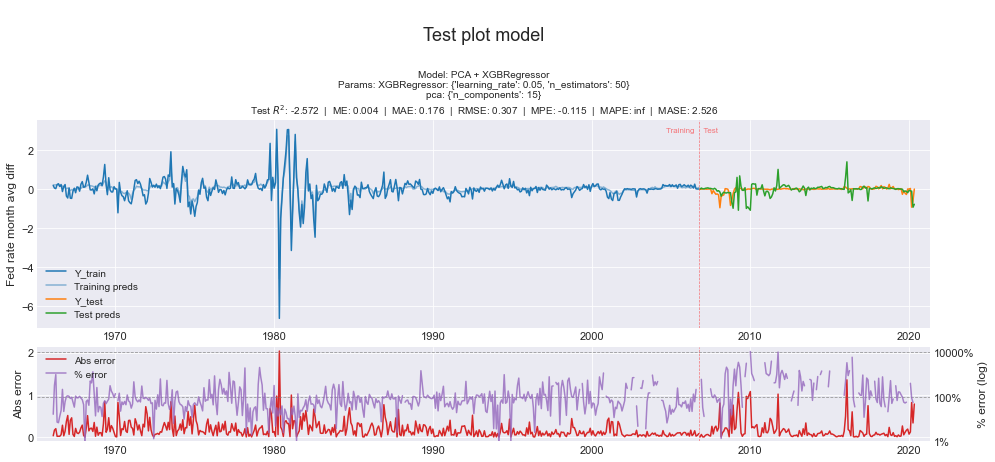

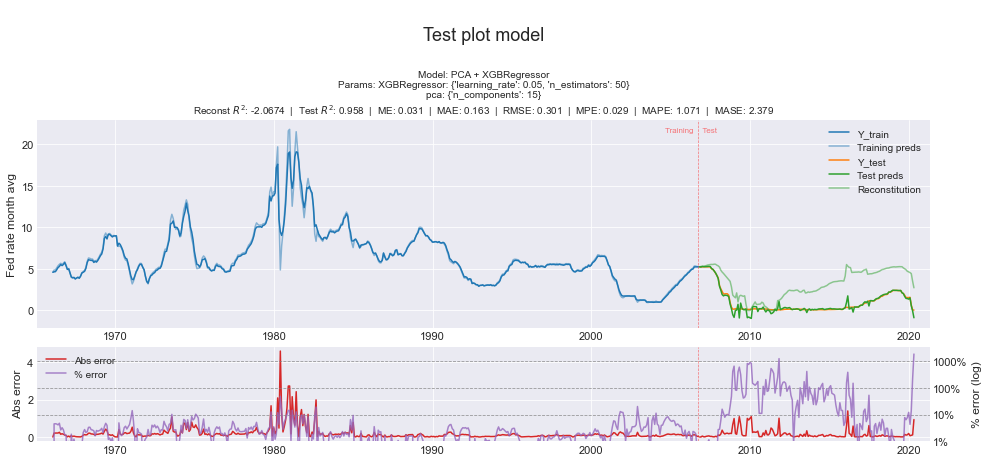

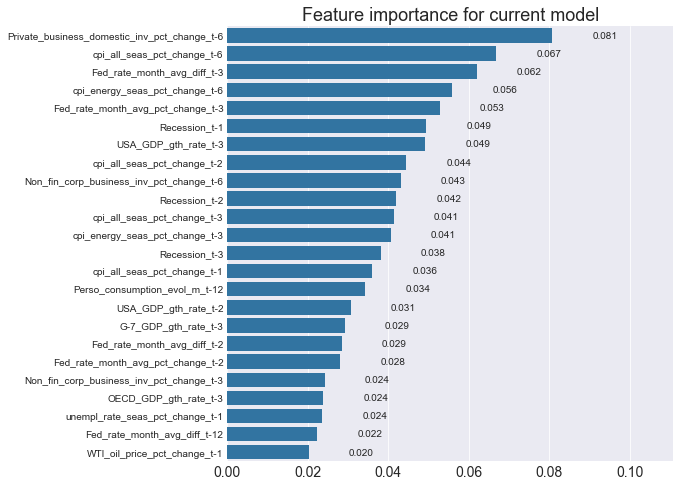

In [12]:
plot_models(
    [model],
    X_train,
    X_test,
    Y_train,
    Y_test,
    date_col="Date",
    predicted_feature=predicted_feature,
    plotted_feature=predicted_feature,
    estimator_params=[best_params],
    type_of_change=None,
    clip_to_zero=False,
    ncols=1,
)

plot_models(
    [model],
    X_train,
    X_test,
    Y_train,
    Y_test,
    date_col="Date",
    predicted_feature=predicted_feature,
    plotted_feature="Fed_rate_month_avg",
    estimator_params=[best_params],
    type_of_change="diff",
    clip_to_zero=True,
    ncols=1,
)

plot_feature_importance(model[-1], features=X_train.columns, pca=model[0], threshold=.02)

In [13]:
file_name_struct = '{:s}_{:s}_score_{:.3f}'
file_name = file_name_struct.format(str(estimator.__class__.__name__),
                                  predicted_feature.replace("_", ""),
                                  model.score(X_test, Y_test[predicted_feature])
                                 ).replace(".", "")
file_name += "_pca" * with_pca

save_files(path=path,
           files={
               file_name + ".pkl": model,
               file_name + ".yaml": best_params
           }
          )

--------------------- 2 file(s) saved succesfully in ./Models/start_196601_end_202005_test_200610/ ---------------------
